In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import scipy.stats as stats
%matplotlib inline

The amount of information is going to be less as the position in the hierarchy increases. And the amount of trust could be random throughout the network.

1 2
possible subordinates [1, 2]
after popping []
##current supervisor 0
####current subordinate 1
i 1
####current subordinate 2
i 1
2 4
possible subordinates [3, 4, 5, 6]
after popping [2]
##current supervisor 1
####current subordinate 3
i 2
####current subordinate 4
i 2
after popping []
##current supervisor 2
####current subordinate 5
i 2
####current subordinate 6
i 2
3 8
possible subordinates [7, 8, 9, 10, 11, 12, 13, 14]
after popping [4, 5, 6]
##current supervisor 3
####current subordinate 7
i 3
####current subordinate 8
i 3
after popping [5, 6]
##current supervisor 4
####current subordinate 9
i 3
####current subordinate 10
i 3
after popping [6]
##current supervisor 5
####current subordinate 11
i 3
####current subordinate 12
i 3
after popping []
##current supervisor 6
####current subordinate 13
i 3
####current subordinate 14
i 3
4 16
possible subordinates [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
after popping [8, 9, 10, 11, 12, 13, 14]
##current supervisor 

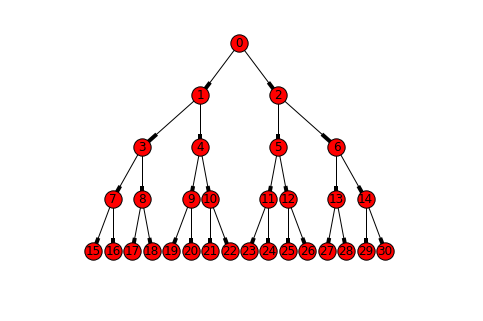

In [2]:
num_levels = 5
num_subordinates = 2
G = nx.DiGraph()
G.add_node(0)
i = 1
leaf_nodes_last_level = [0]
nodes_in_levels = defaultdict(list)
nodes_in_levels[0] = [0]
levels_of_nodes = dict()
levels_of_nodes[0] = 0

for i in range(1, num_levels):
    print i, pow(2,i)
    num_nodes_this_level = pow(2,i)
    possible_subordinates = range(G.number_of_nodes(), G.number_of_nodes()+ num_nodes_this_level )
    leaf_nodes_next_level = list(possible_subordinates)
    print "possible subordinates", possible_subordinates

    while len(leaf_nodes_last_level) > 0:
        current_supervisor = leaf_nodes_last_level.pop(0)
        print "after popping", leaf_nodes_last_level
        print "##current supervisor", current_supervisor
        for j in range(num_subordinates):
            current_subordinate = possible_subordinates.pop(0)
            print "####current subordinate", current_subordinate
            G.add_edge(current_supervisor, current_subordinate)
            print "i", i
            nodes_in_levels[i].append(current_subordinate)
            levels_of_nodes[current_subordinate] = i
    leaf_nodes_last_level = list(leaf_nodes_next_level)
        
# pos = hierarchy_pos(btree2, 0)
#nx.draw(btree2,pos=nx.draw_networkx(btree2),with_labels=True,arrows=True)
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw(G,pos,with_labels=True,arrows=True)

print leaf_nodes_last_level
print leaf_nodes_next_level

Our first assumption is that the deeper the level the less the initial information $H$ in the node. And we will distribute the initial $\alpha$ value distributed randomly using a lognormal distributions with parameter $\mu$ and $\sigma$

In [3]:
def sample_h(level, mean_info = 0.7, sd_info = 0.05, dmu = 0.1):
    ## the distribution will be Truncated between 0 and 1
    lower, upper = 0, 1
    ## The distribution
    mu = mean_info - (dmu * (level-1))
    sigma = sd_info
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    s = X.rvs(1)[0]
    return s

def sample_alpha(mu = 0.5, sigma = 0.1):
    ## the distribution will be Truncated between 0 and 1
    lower, upper = 0, 1
    ## The distribution
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    s = X.rvs(1)[0]
    return s

def sample_change_in_alpha(mu = 0.1, sigma = 0.01):
    ## the distribution will be Truncated between 0 and 1
    lower, upper = 0, 1
    ## The distribution
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    s = X.rvs(1)[0]
    return s

We do not have any problem assigning H in node 0 as there is no edge pointing towards him. So for mu, dmu * (level -1 ) is not a problem.

In [4]:
mean_trust = 0.5
sd_trust = 0.2
mean_info_higehst_level = 0.7
dmu_each_level = 0.1
mean_change_in_alpha = 0.05
sd_change_in_alpha = 0.001

for edge in G.edges():
    subordinate_node = edge[1]
    current_h = sample_h(levels_of_nodes[subordinate_node], mean_info = mean_info_higehst_level, dmu = dmu_each_level)
    current_alpha = sample_alpha(mean_trust, sd_trust)
    G[edge[0]][edge[1]]['H'] = current_h
    G[edge[0]][edge[1]]['alpha'] = current_alpha
    

In [5]:
nx.get_edge_attributes(G, 'alpha')

{(0, 1): 0.25738608564959031,
 (0, 2): 0.38992261980473458,
 (1, 3): 0.50582739585299663,
 (1, 4): 0.50637156987166554,
 (2, 5): 0.21305441658851948,
 (2, 6): 0.49804115016936451,
 (3, 7): 0.55504069799321276,
 (3, 8): 0.28284500417387848,
 (4, 9): 0.3825246060712737,
 (4, 10): 0.37825354927975507,
 (5, 11): 0.75369695551546434,
 (5, 12): 0.50710466984877967,
 (6, 13): 0.25927484587982952,
 (6, 14): 0.41045277370618444,
 (7, 15): 0.36157082926690309,
 (7, 16): 0.64278483858649926,
 (8, 17): 0.94213957685675065,
 (8, 18): 0.51133807114997876,
 (9, 19): 0.6488177342502478,
 (9, 20): 0.19941796807438167,
 (10, 21): 0.70560651838466271,
 (10, 22): 0.64000915451849671,
 (11, 23): 0.46013676741079457,
 (11, 24): 0.63903801771509217,
 (12, 25): 0.39070255547930166,
 (12, 26): 0.46219778201836936,
 (13, 27): 0.70201978737218651,
 (13, 28): 0.1411748801134991,
 (14, 29): 0.34944291740099276,
 (14, 30): 0.31810535934402195}

In [6]:
nx.get_edge_attributes(G, 'H')

{(0, 1): 0.7245682096202587,
 (0, 2): 0.68566948408537454,
 (1, 3): 0.56594835092242757,
 (1, 4): 0.5420247299801455,
 (2, 5): 0.55390373254942871,
 (2, 6): 0.63187908066517084,
 (3, 7): 0.45864198407749535,
 (3, 8): 0.56026789373551478,
 (4, 9): 0.55777226621953724,
 (4, 10): 0.57707635605416407,
 (5, 11): 0.54627761953516729,
 (5, 12): 0.46616711826561474,
 (6, 13): 0.5057055742524138,
 (6, 14): 0.4580460121297546,
 (7, 15): 0.31059450908772529,
 (7, 16): 0.26971307348460205,
 (8, 17): 0.43142450298128665,
 (8, 18): 0.36103370803061191,
 (9, 19): 0.48465580208007825,
 (9, 20): 0.33661326198722491,
 (10, 21): 0.43608811508082884,
 (10, 22): 0.53181613740216349,
 (11, 23): 0.46663406490068282,
 (11, 24): 0.40588706710160283,
 (12, 25): 0.36054221176595513,
 (12, 26): 0.45360270485656151,
 (13, 27): 0.32737432084340767,
 (13, 28): 0.45171426538722453,
 (14, 29): 0.4402359446347503,
 (14, 30): 0.37516350332550424}

In [7]:
## Order can be -1 or 1
flips = {1:-1, -1:1}
order = -1
delta = 0.25 ## The higher the delta the more skeptical we are
root_node = 0
bits = dict()
bits[root_node] = order

for edge in list(nx.bfs_edges(G ,root_node)):
    source_node = edge[0]
    target_node = edge[1]
    source_bit = bits[source_node]
    print "##", edge, source_bit
    current_alpha = G[source_node][target_node]['alpha']
    current_info = G[source_node][target_node]['H']
    processed_info = current_alpha + current_info * source_bit
    print "processed_info", processed_info, "delta", delta
    if processed_info >= delta:
        ## Keeping
        print "Keeping"
        processed_bit = source_bit
        new_alpha = current_alpha + sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
        if new_alpha > 1:
            new_alpha = 1
        elif new_alpha < 0:
            new_alpha = 0
        G[source_node][target_node]['alpha'] = new_alpha
    else:
        ## Flipping
        print "Flipping"
        processed_bit = flips[source_bit]
        new_alpha = current_alpha - sample_change_in_alpha(mean_change_in_alpha, sd_change_in_alpha)
        if new_alpha > 1:
            new_alpha = 1
        elif new_alpha < 0:
            new_alpha = 0
        G[source_node][target_node]['alpha'] = new_alpha
    bits[target_node] = processed_bit
    print "current_alpha", current_alpha, "new_alpha", new_alpha

## (0, 1) -1
processed_info -0.467182123971 delta 0.25
Flipping
current_alpha 0.25738608565 new_alpha 0.208328817712
## (0, 2) -1
processed_info -0.295746864281 delta 0.25
Flipping
current_alpha 0.389922619805 new_alpha 0.341481631828
## (1, 3) 1
processed_info 1.07177574678 delta 0.25
Keeping
current_alpha 0.505827395853 new_alpha 0.556455504842
## (1, 4) 1
processed_info 1.04839629985 delta 0.25
Keeping
current_alpha 0.506371569872 new_alpha 0.557346500353
## (2, 5) 1
processed_info 0.766958149138 delta 0.25
Keeping
current_alpha 0.213054416589 new_alpha 0.263590324376
## (2, 6) 1
processed_info 1.12992023083 delta 0.25
Keeping
current_alpha 0.498041150169 new_alpha 0.547775991932
## (3, 8) 1
processed_info 0.843112897909 delta 0.25
Keeping
current_alpha 0.282845004174 new_alpha 0.333196206042
## (3, 7) 1
processed_info 1.01368268207 delta 0.25
Keeping
current_alpha 0.555040697993 new_alpha 0.606113908822
## (4, 9) 1
processed_info 0.940296872291 delta 0.25
Keeping
current_alpha 0.38

In [8]:
print bits

{0: -1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1}


In [9]:
Counter(bits.values())

Counter({-1: 1, 1: 30})

In [10]:
labels = dict()
alphas = nx.get_edge_attributes(G, 'alpha')
Hs = nx.get_edge_attributes(G, 'H')
for key in G.edges():
    print key
    current_alpha = round(alphas[key], 1)
    current_H = round(Hs[key], 1)
    labels[key] = (current_alpha, current_H)
print labels

(0, 1)
(0, 2)
(1, 3)
(1, 4)
(2, 5)
(2, 6)
(3, 8)
(3, 7)
(4, 9)
(4, 10)
(5, 11)
(5, 12)
(6, 13)
(6, 14)
(7, 16)
(7, 15)
(8, 17)
(8, 18)
(9, 19)
(9, 20)
(10, 21)
(10, 22)
(11, 24)
(11, 23)
(12, 25)
(12, 26)
(13, 27)
(13, 28)
(14, 29)
(14, 30)
{(1, 3): (0.6, 0.6), (14, 30): (0.4, 0.4), (11, 23): (0.5, 0.5), (10, 21): (0.8, 0.4), (7, 16): (0.7, 0.3), (11, 24): (0.7, 0.4), (3, 7): (0.6, 0.5), (2, 5): (0.3, 0.6), (6, 14): (0.5, 0.5), (4, 9): (0.4, 0.6), (7, 15): (0.4, 0.3), (5, 12): (0.6, 0.5), (10, 22): (0.7, 0.5), (4, 10): (0.4, 0.6), (2, 6): (0.5, 0.6), (9, 20): (0.2, 0.3), (5, 11): (0.8, 0.5), (12, 25): (0.4, 0.4), (1, 4): (0.6, 0.5), (13, 28): (0.2, 0.5), (8, 17): (1.0, 0.4), (14, 29): (0.4, 0.4), (0, 1): (0.2, 0.7), (12, 26): (0.5, 0.5), (13, 27): (0.8, 0.3), (3, 8): (0.3, 0.6), (8, 18): (0.6, 0.4), (6, 13): (0.3, 0.5), (9, 19): (0.7, 0.5), (0, 2): (0.3, 0.7)}


In [11]:
labels = dict()
alphas = nx.get_edge_attributes(G, 'alpha')
Hs = nx.get_edge_attributes(G, 'H')
for key in G.edges():
    #print key
    current_alpha = round(alphas[key], 1)
    current_H = round(Hs[key], 1)
    labels[key] = (current_alpha, current_H)
print labels

{(1, 3): (0.6, 0.6), (14, 30): (0.4, 0.4), (11, 23): (0.5, 0.5), (10, 21): (0.8, 0.4), (7, 16): (0.7, 0.3), (11, 24): (0.7, 0.4), (3, 7): (0.6, 0.5), (2, 5): (0.3, 0.6), (6, 14): (0.5, 0.5), (4, 9): (0.4, 0.6), (7, 15): (0.4, 0.3), (5, 12): (0.6, 0.5), (10, 22): (0.7, 0.5), (4, 10): (0.4, 0.6), (2, 6): (0.5, 0.6), (9, 20): (0.2, 0.3), (5, 11): (0.8, 0.5), (12, 25): (0.4, 0.4), (1, 4): (0.6, 0.5), (13, 28): (0.2, 0.5), (8, 17): (1.0, 0.4), (14, 29): (0.4, 0.4), (0, 1): (0.2, 0.7), (12, 26): (0.5, 0.5), (13, 27): (0.8, 0.3), (3, 8): (0.3, 0.6), (8, 18): (0.6, 0.4), (6, 13): (0.3, 0.5), (9, 19): (0.7, 0.5), (0, 2): (0.3, 0.7)}


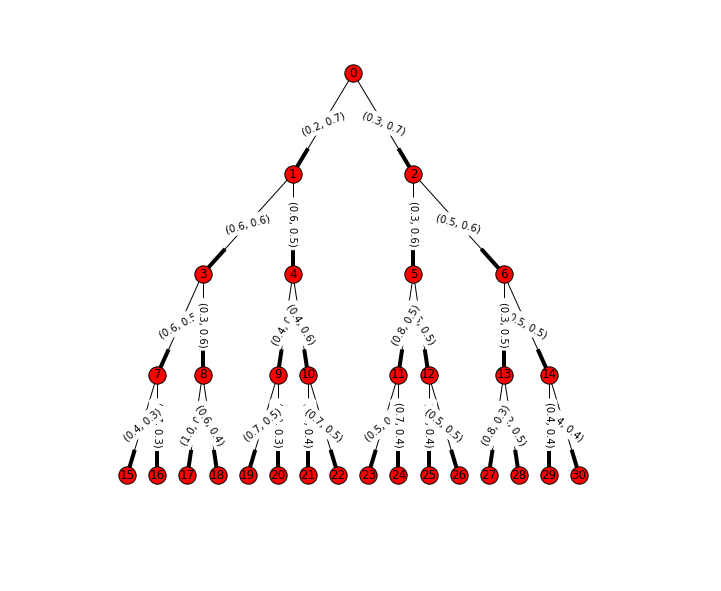

In [12]:
plt.figure(figsize=(12,10))
pos=nx.nx_pydot.graphviz_layout(G,prog='dot')
nx.draw_networkx_edge_labels(G,pos=nx.nx_pydot.graphviz_layout(G,prog='dot'), edge_labels = labels)
nx.draw(G,pos,with_labels=True,arrows=True)

In [13]:
{(0, 1): (0., 0.9), (1, 3): (0.7, 0.7), (1, 4): (0.7, 0.7), (2, 6): (0.3, 0.6), (2, 5): (0.9, 0.8), (0, 2): (0.5, 0.9)}

{(0, 1): (0.0, 0.9),
 (0, 2): (0.5, 0.9),
 (1, 3): (0.7, 0.7),
 (1, 4): (0.7, 0.7),
 (2, 5): (0.9, 0.8),
 (2, 6): (0.3, 0.6)}